## Analyze floorplan's structure with Jupyter Notebook

Jupyter Notebook is a nice tool for data analysis since it can bind analysis, code, and result together with interactive process. However, floor plan analysis has been done in a seprate software such as depthmap and it could not utilize the power of interactive process. In this notebook, I'd like to demonstrate how we can analyze a floor plan's network structure with Jupyter Notebook.

We are going to use GeoPandas to manage spatial data and NetworkX to calculate network properties. 

In [1]:
import geopandas as gpd
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import os

import warnings
warnings.filterwarnings('ignore')

### Dataset

We will import floorplan data from esri's FileGDB. You can use any type of spatial data supported by OGR driver such as shp, dxf, and dwg. In this notebook, the key data set is room polygons. In our dataset, we created room boundary polygons for all rooms including circulation spaces. Other lines are just graphics irrelevant from actual analysis.

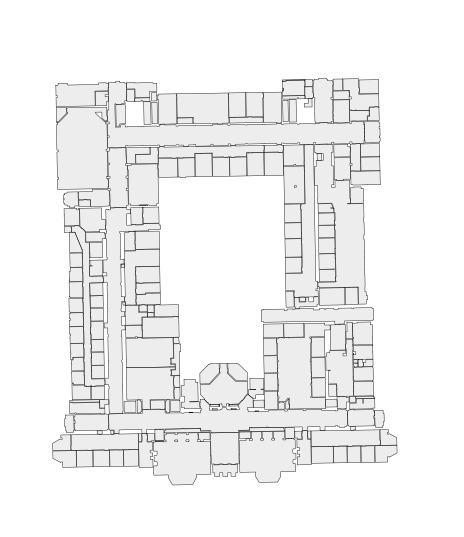

In [6]:
# read room polygons in esri gdb
gdb_path = os.path.expanduser('~/work/test-data/test.gdb')
rooms = gpd.read_file(gdb_path, layer=2)  # room polygon is the second layer in our gdb

# let's look at them
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.axison = False
ax.set_aspect('equal')
rooms.plot(ax=ax, linewidth=0.3, color='#DDDDDD')
plt.show()

### Original floorplan

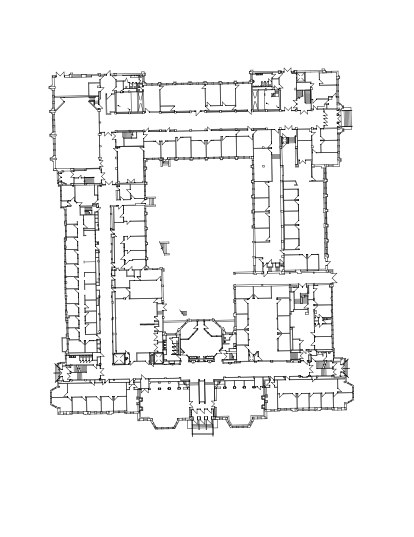

In [7]:
graphics = gpd.read_file(gdb_path, layer=3)  # third layer in the gdb

fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.axison = False
ax.set_aspect('equal')
graphics.plot(ax=ax, linewidth=0.3, color='k')
plt.show()

### Administrative information on rooms

In [10]:
# Luckily we have a table with information such as department and room type.
rooms_info = pd.read_csv("rooms_0221_01.csv")
rooms_info.RmRecNbr = rooms_info.RmRecNbr.apply(str)

# Let's join this table with the floorplan by rmrecnbr, which is a room unique id.
rooms = rooms.merge(rooms_info, how='left', on="RmRecNbr")
print(rooms.head())


  BldRecNbr BldRecNbr_RmNbr  Elevation Floor  Height  RmNbr RmRecNbr  \
0   1000221     10002211360      873.0    01    15.5   1360  2035443   
1   1000221    10002211360H      873.0    01    15.5  1360H  2035450   
2   1000221    10002211360F      873.0    01    15.5  1360F  2035448   
3   1000221    10002211360E      873.0    01    15.5  1360E  2035447   
4   1000221    10002211360D      873.0    01    15.5  1360D  2035446   

   Shape_Area  Shape_Length bldfloor  \
0  609.261837    131.812581     None   
1    9.719211     13.123113     None   
2  168.376348     56.259533     None   
3  125.497347     45.021328     None   
4  123.438036     44.687609     None   

                                            geometry           dept_descr  \
0  (POLYGON ((13294002.41666667 282543.9058398902...  School of Education   
1  (POLYGON ((13294032.12007874 282547.0318241417...  School of Education   
2  (POLYGON ((13294067.01935695 282532.960958004,...  School of Education   
3  (POLYGON ((1329

#### Color by room type

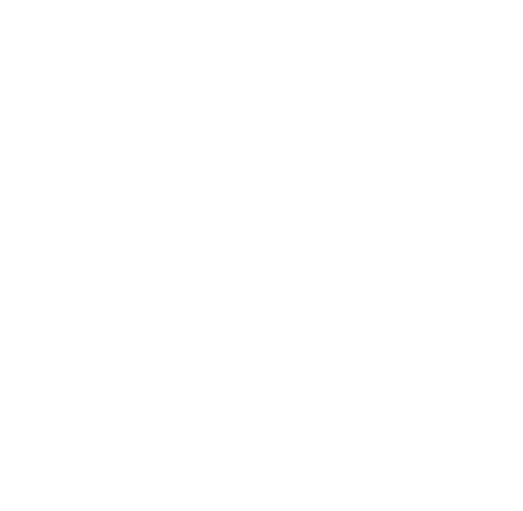

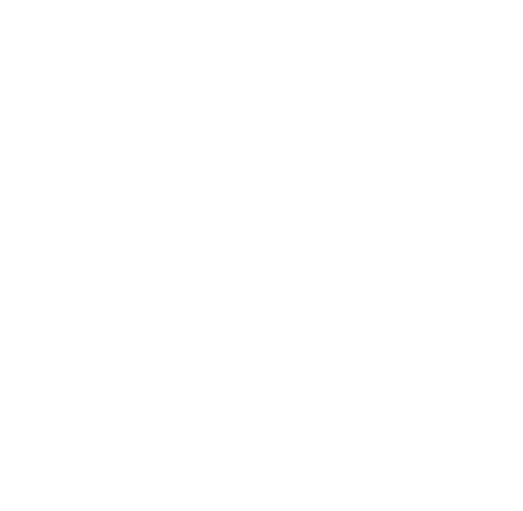

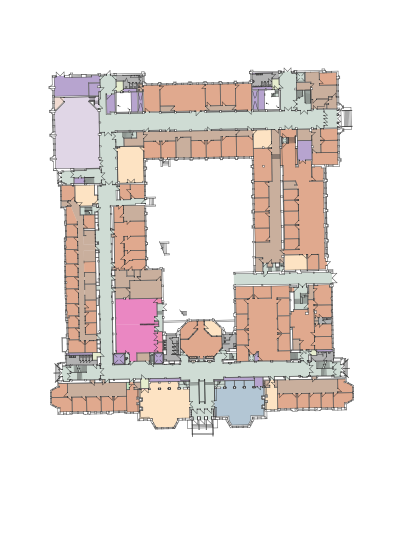

In [11]:
# then plot the nodes over room polygons
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.0, column='rmtyp_descr50', cmap='Accent')
graphics.plot(ax=ax, linewidth=0.3, color='#333333')
ax.set_aspect('equal')
plt.show()

#### Color by department

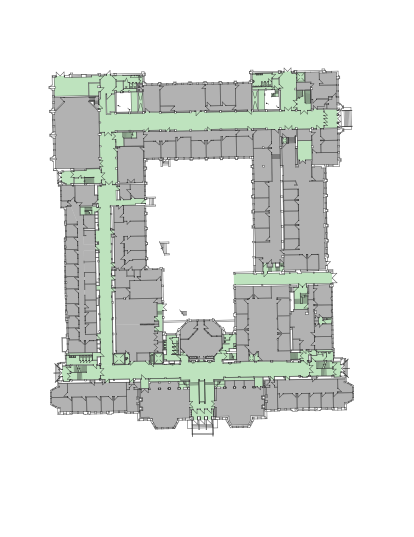

In [12]:
# then plot the nodes over room polygons
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.0, column='dept_descr', cmap='Accent')
graphics.plot(ax=ax, linewidth=0.3, color='#333333')
ax.set_aspect('equal')
plt.show()

### Let's create nodes at the centroid of each room

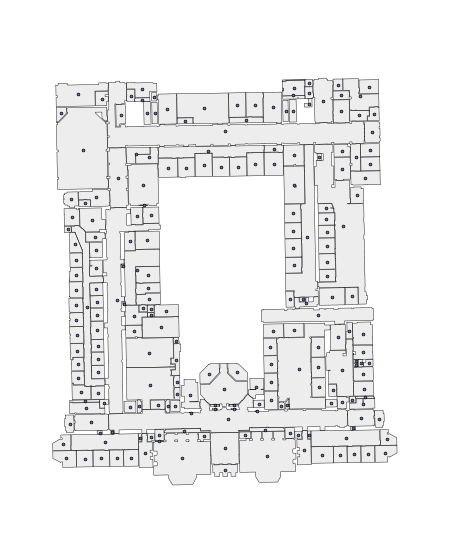

In [13]:
nodes = rooms.geometry.centroid

# then plot the nodes over room polygons
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.3, color='#DDDDDD')
nodes.plot(ax=ax, markersize=2, color='#6677AA')
ax.set_aspect('equal')
plt.show()

### Create edges

Room polygons touch each other if the rooms are connected directly or through doors. If there is a wall between two rooms, there should be a gap between the room polygons. We will give some threshold judging 'touch'.

In [14]:
threshold = 0.02

# dictionary for edge geometry
lines = {'geometry':[], 'from':[], 'to':[]}

for index1, room1 in rooms.iterrows():
    for index2, room2 in rooms.iterrows():
        if room1.geometry.buffer(threshold).intersects(room2.geometry.buffer(threshold)) \
            and index1 > index2:
            lines["from"].append(index1)
            lines["to"].append(index2)
            lines["geometry"].append(LineString([room1.geometry.centroid, room2.geometry.centroid]))

# geodataframe for edges
edges = gpd.GeoDataFrame(lines)

### Let's see how rooms are connected

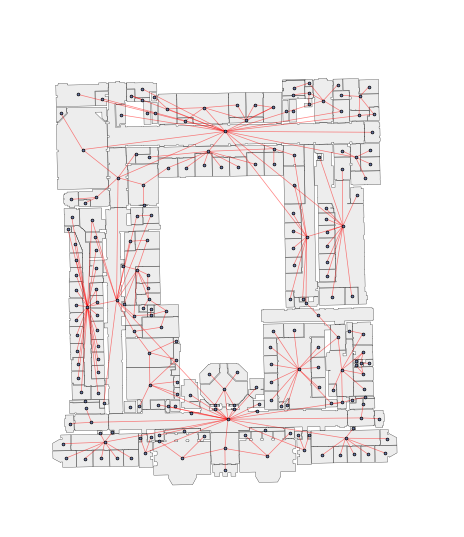

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.2, color='#DDDDDD')
edges.plot(ax=ax, linewidth=0.5, color='r', alpha=0.5)
rooms.geometry.centroid.plot(ax=ax, markersize=2, color='#6677AA')
ax.set_aspect('equal')
plt.show()

## Let's calculate some network measures.

In [16]:
room_network = nx.Graph()
for i, edge in edges.iterrows():
    room_network.add_edge(edge["from"], edge["to"])

# calculate closeness and add the values to rooms
closeness = nx.closeness_centrality(room_network)
rooms['closeness'] = pd.Series(closeness)

# calculate betweenness and add the values to rooms
betweenness = nx.betweenness_centrality(room_network)
rooms['betweenness'] = pd.Series(betweenness)

### color rooms by closeness

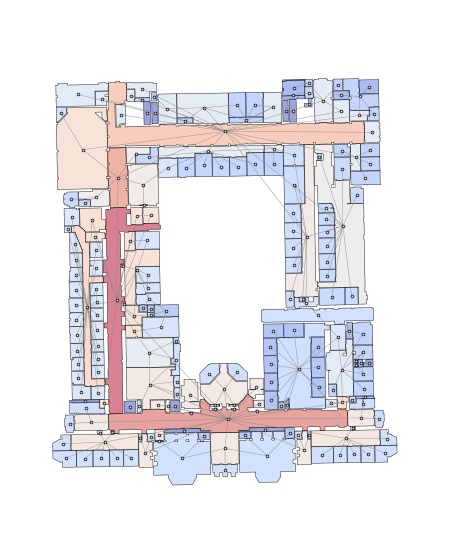

In [17]:
# color rooms by closeness
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.3, column='closeness', cmap='coolwarm')
edges.plot(ax=ax, linewidth=0.3, color='#888888')
rooms.geometry.centroid.plot(ax=ax, markersize=2, color='#DDDDDD')
ax.set_aspect('equal')
plt.show()

#### Distribution of closeness centrality

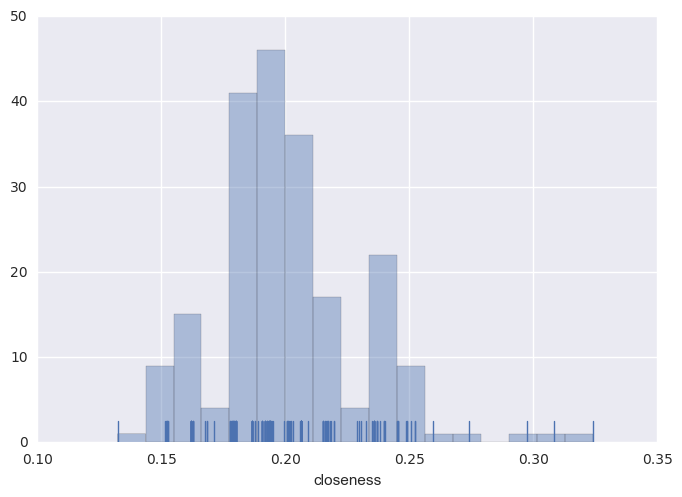

In [26]:
import seaborn as sns
sns.set(color_codes=True)
clo = rooms["closeness"][rooms["closeness"].notnull()]
sns.distplot(clo, kde=False, rug=True);
sns.plt.show()

## Identify 'regions', or naturally-grouped rooms in the floor

In [27]:
# find community structure in room network using Girvan-Newman algorithm
comp = nx.girvan_newman(room_network)
k = 6  ## number of communities

community = dict()
import itertools
limited = itertools.takewhile(lambda c: len(c) <= k, comp)
comm_structure = None
for communities in limited:
    comm_structure = (list(c for c in communities))

for cid, comm in enumerate(comm_structure):
    for node in comm:
        community[node] = cid


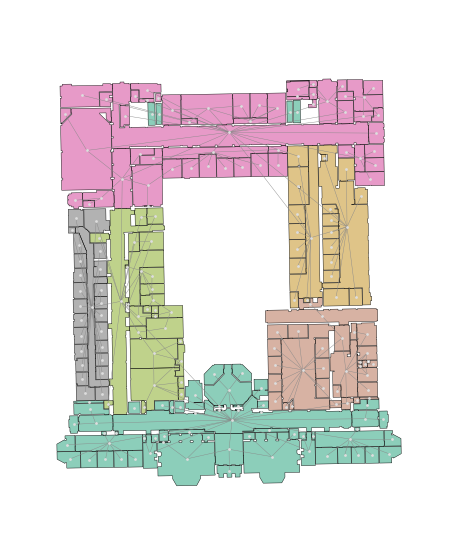

In [28]:
rooms['community'] = pd.Series(community)

# color rooms by community
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.3, column='community', cmap='Dark2')
edges.plot(ax=ax, linewidth=0.3, color='#888888')
rooms.geometry.centroid.plot(ax=ax, markersize=2, color='#DDDDDD')
ax.set_aspect('equal')
plt.show()

### Closeness by room type

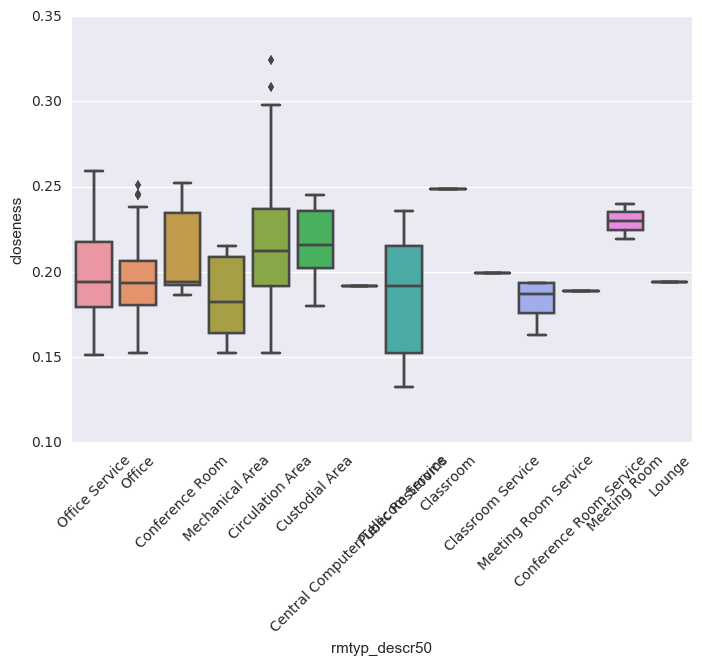

In [30]:
ax = sns.boxplot(x="rmtyp_descr50", y="closeness", data=rooms)
plt.xticks(rotation=45)
sns.plt.show()

### Closeness by region

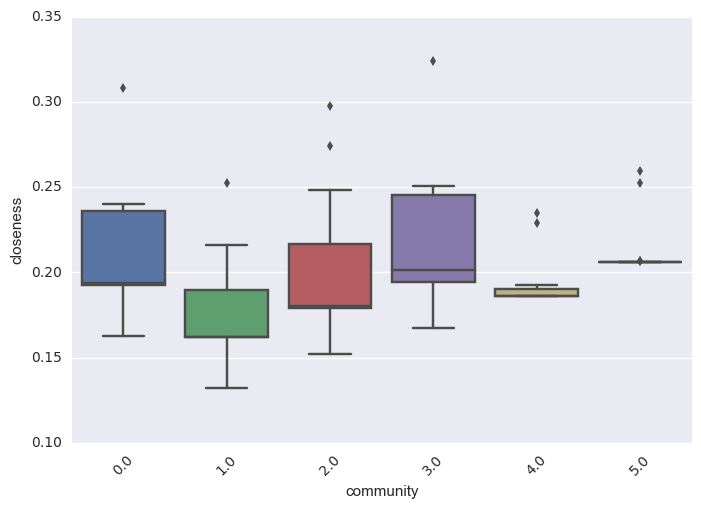

In [31]:
ax = sns.boxplot(x="community", y="closeness", data=rooms)
plt.xticks(rotation=45)
sns.plt.show()